In [1]:
import requests
import pandas as pd
from datetime import datetime
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
def get_binance_ohlc(symbol, interval, limit=1000):
    url = f'https://api.binance.com/api/v1/klines'
    params = {
        'symbol': symbol,
        'interval': interval,
        'limit': limit
    }
    response = requests.get(url, params=params)
    data = response.json()
    
    ohlc = []
    for item in data:
        ohlc.append({
            'timestamp': datetime.fromtimestamp(item[0] / 1000),
            'open': float(item[1]),
            'high': float(item[2]),
            'low': float(item[3]),
            'close': float(item[4]),
            'volumn': float(item[5])

        })
    df = pd.DataFrame(ohlc)
    # df.set_index('timestamp', inplace=True)
    return df



In [2]:
from datetime import datetime, timedelta

def generate_date_list(start_date_str, end_date_str, interval_days=4):
    # Convert string inputs to datetime objects
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
    end_date = datetime.strptime(end_date_str, '%Y-%m-%d')
    
    # Generate list of dates
    date_list = []
    current_date = start_date
    while current_date <= end_date:
        date_list.append(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=interval_days)
    
    return date_list

In [3]:
def get_binance_ohlc_time(symbol, interval, start_str, end_str):
    print(start_str,"->",end_str)
    url = f'https://api.binance.com/api/v3/klines'
    
    # Convert start and end times to milliseconds since epoch
    start_ts = int(datetime.strptime(start_str, '%Y-%m-%d %H:%M:%S').timestamp() * 1000)
    end_ts = int(datetime.strptime(end_str, '%Y-%m-%d %H:%M:%S').timestamp() * 1000)
    
    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_ts,
        'endTime': end_ts
    }
    response = requests.get(url, params=params)
    data = response.json()
    ohlc = []
    for item in data:
        ohlc.append({
            'timestamp': datetime.fromtimestamp(item[0] / 1000),
            'open': float(item[1]),
            'high': float(item[2]),
            'low': float(item[3]),
            'close': float(item[4]),
            'volumn': float(item[5])
        })
    
    df = pd.DataFrame(ohlc)
    df.reset_index(drop=True, inplace=True)

    # df.set_index('timestamp', inplace=True)
    return df

In [24]:
def rule(df_btc, df, tp=1, sl=5, money=1000, model = None, num_random=10000, window_test=10, seq=30):
    number_high = 0
    number_low = 0
    cannot_break = 0
    results = []
    list_reward = []
    balance = 0
    price_line = []
    # df['fluct'] = (df['close'] - df['open']) / df['open'] * 100
    # df['amp'] = (df['high'] - df['low']) / df['low'] * 100

    # df_btc['fluct'] = (df_btc['close'] - df_btc['open']) / df_btc['open'] * 100
    # df_btc['amp'] = (df_btc['high'] - df_btc['low']) / df_btc['low'] * 100

    index_condition = []
    if model is None:
        index_condition = np.random.randint(100, len(df), num_random)
    else:
        for i in range(seq+1, len(df)-1, window_test):
            x_array = df.iloc[i-seq:i].values[:,1:].astype(np.float32)

            min_vol = np.min(x_array[:,-1])
            x_array[:,-1] = x_array[:,-1]/min_vol
            min_price = np.min(x_array[:,:4])
            max_price = np.max(x_array[:,:4])
            x_array[:,:4] = (x_array[:,:4] - min_price) / (max_price - min_price)


            x_array = np.array([x_array]).reshape(1, -1)
            # print(x_array.shape)
            dtest = xgb.DMatrix(x_array)
            y_pred_prob = model.predict(dtest)
            if y_pred_prob == 1:
                index_condition.append(i)

    index_condition = sorted(index_condition)
    for i in index_condition:
        a = df['open'].iloc[i]
        high_check = False
        low_check = False
        for j in range(i, i+10):
            if j >= len(df):
                break
            high_check = df['high'].iloc[j] >= (1+sl*0.01) * a
            low_check = df['low'].iloc[j] <= (1-tp*0.01) * a
            if high_check and low_check:
                print("check lai")
            if high_check:
                balance += -money*sl/100
                list_reward.append(balance)
                price_line.append(j)
                number_high+=1
                results.append((i, df.iloc[i]['timestamp'], df.iloc[j]['timestamp'], "high"))
                break
            if low_check:
                price_line.append(j)
                balance += money*tp/100
                list_reward.append(balance)
                number_low+=1
                # print(df.iloc[i])
                # print("low", j-i)
                results.append((i, df.iloc[i]['timestamp'], df.iloc[j]['timestamp'], "low"))
                break
        if not high_check and not low_check and j<len(df):
            if df.iloc[j]['close'] < a:
                # print("win: ", df.iloc[j]['close'], df.iloc[i]['open'], money * (1 - df.iloc[j]['close'] / df.iloc[i]['open']))
                balance += money * (1 - df.iloc[j]['close'] / df.iloc[i]['open'])
            else:
                # print("lose: ", df.iloc[j]['close'], df.iloc[i]['open'], -money * (df.iloc[j]['close'] / df.iloc[i]['open']-1))

                balance += -money * (df.iloc[j]['close'] / df.iloc[i]['open']-1)
            list_reward.append(balance)
            price_line.append(j)
            results.append((i, df.iloc[i]['timestamp'], df.iloc[j]['timestamp'], "not"))
            cannot_break += 1
    prices_list = df.loc[price_line, 'open'].tolist()

    print("num points: ", len(index_condition), "number_low/all_point", round(number_low/(number_low+number_high+0.01), 3), "cannot_break", cannot_break)

    return results, index_condition, number_high, number_low, list_reward, prices_list


In [5]:
# start = "2023-06-12"
# end = "2024-08-12"
# list_day = generate_date_list(start, end, 5)
# df_all = []
# symb = "BTCUSDT"
# interval = "1d"
# for i in range(len(list_day)-1):
#     df = get_binance_ohlc_time(symb, interval, list_day[i]+" 00:15:00", list_day[i+1]+" 00:00:00")
#     df_all.append(df)
# df_all = pd.concat(df_all,ignore_index=True, axis=0)
# df_all.to_csv(f"{symb}_{start}_{end}_{interval}.csv", index=False)
# df_all = pd.read_csv(f"{symb}_{start}_{end}_{interval}.csv")
df_all = pd.read_csv(f"ORDIUSDT_2023-06-12_2024-08-11_15m.csv")

In [20]:
df = df_all.iloc[:15000].reset_index(drop=True)#.drop(columns=['fluct', 'amp'])
display(df.head(1))
display(df.tail(2))
rs, idcond, high_check, low_check, list_reward, prices_list = rule(df, df, tp=3, sl=3)


,timestamp,open,high,low,close,volumn
0,2023-11-07 19:00:00,5.905,11.8,5.905,10.0,1840312.07


,timestamp,open,high,low,close,volumn
14998,2024-04-12 00:30:00,71.639,71.672,71.264,71.394,10341.35
14999,2024-04-12 00:45:00,71.395,71.461,71.000,71.030,15166.52


check lai
check lai
check lai
check lai
check lai
check lai
check lai
check lai
check lai
check lai
check lai
check lai
check lai
num points:  10000 number_low/all_point 0.482 cannot_break 5949


Accuracy: 76.24%


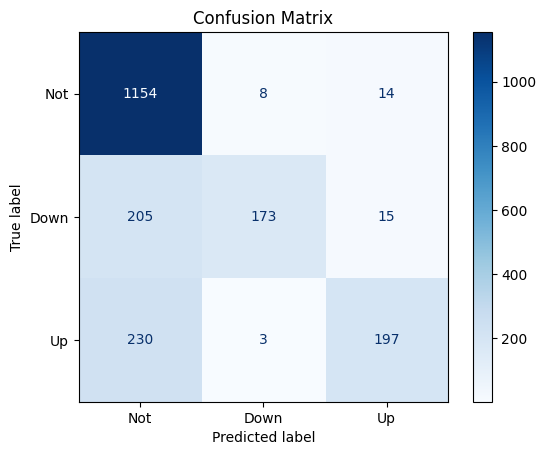

In [35]:
def create_dataset(df, rs, sequence_length):
    x = []
    y = []
    for point in rs:
        index = point[0]
        if point[-1] == "low":
            y.append(1)
        elif point[-1] == "high":
            y.append(2)
        else:
            y.append(0)
        x_array = df_all.iloc[index-sequence_length:index].values[:,1:].astype(np.float32)
        min_vol = np.min(x_array[:,-1])
        x_array[:,-1] = x_array[:,-1]/min_vol
        min_price = np.min(x_array[:,:4])
        max_price = np.max(x_array[:,:4])
        x_array[:,:4] = (x_array[:,:4] - min_price) / (max_price - min_price)
        x.append(x_array)
    return x, y

x, y = create_dataset(df_all, rs, 30)
x = np.array(x)
y = np.array(y)
x = x.reshape(x.shape[0], -1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)


param = {
    'max_depth': 25,
    'eta': 0.1,
    'objective': 'multi:softmax',  # Multiclass classification
    'num_class': 3,                # Number of classes
    'eval_metric': 'merror'       # Multiclass classification error rate
}

# Train the model
num_round = 100
bst = xgb.train(param, dtrain, num_round)

# Make predictions
y_pred_prob = bst.predict(dtest)
y_pred = y_pred_prob.astype(int) # Convert predicted probabilities to class labels

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Not', 'Down', "Up"])
cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [6]:
bst = xgb.Booster()


In [34]:
bst.save_model('xgboost_model_ORDI_15m_15k_first_maxdepth20_3class.json')

In [37]:
df = df_all.iloc[18000:].reset_index(drop=True)#.drop(columns=['fluct', 'amp'])
display(df.head(1))
display(df.tail(2))
rs2, idcond, high_check, low_check, list_reward, prices_list = rule(df, df, tp=3, sl=3, model=bst, num_random=1000, window_test=1, seq=30)
list_reward[-1]

,timestamp,open,high,low,close,volumn
0,2024-05-13 07:00:00,36.31,36.5,36.3,36.46,2092.03


,timestamp,open,high,low,close,volumn
8515,2024-08-09 23:45:00,27.61,27.67,27.48,27.67,6915.32
8516,2024-08-10 00:00:00,27.67,27.81,27.60,27.80,2958.34


num points:  136 number_low/all_point 0.58 cannot_break 86


566.249859443051

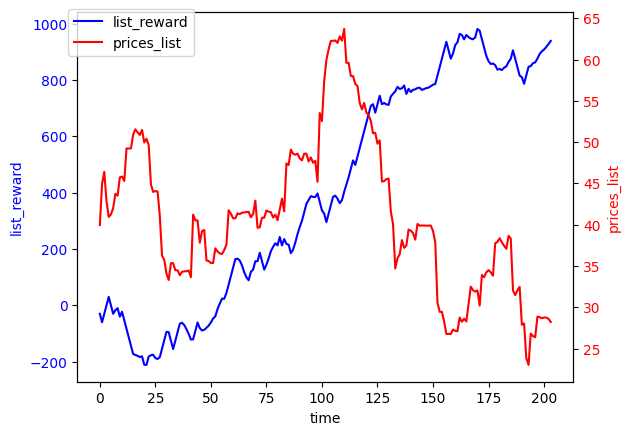

In [33]:
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots()

ax1.plot(list_reward, 'b-', label='list_reward')
ax1.set_xlabel('time')
ax1.set_ylabel('list_reward', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(prices_list, 'r-', label='prices_list')
ax2.set_ylabel('prices_list', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# plt.title('Two Lists with Different Scales')
plt.show()


In [8]:
def create_dataset(df, rs, sequence_length):
    x = []
    y = []
    for point in rs:
        index = point[0]
        y.append(point[-1] == "low")
        x_array = df_all.iloc[index-sequence_length:index].values[:,1:].astype(np.float32)
        x_array[:,-1] = x_array[:,-1]/20000
        x.append(x_array)
    return x, y

        
    

In [9]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, random_split

# Hyperparameters
input_size = 5  # Single feature (price)
hidden_size = 50  # Number of features in hidden state
num_layers = 2  # Number of stacked LSTM layers
output_size = 1  # Predict the next price
num_epochs = 100
learning_rate = 0.001
sequence_length = 60  # Number of past prices to use for prediction
train_ratio = 0.9
d_model = 64  # Embedding dimension
nhead = 4  # Number of attention heads
num_encoder_layers = 2  # Number of transformer encoder layers
fc1_size = 32  # Number of neurons in the first fully connected layer
fc2_size = 16
x, y = create_dataset(df_all, rs, sequence_length)

# Convert to PyTorch tensors
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

print(x.shape)
# Split data into training and validation sets
dataset = TensorDataset(x, y)
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_encoder_layers, output_size, sequence_length):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Linear(input_size, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, sequence_length, d_model))  # Positional encoding
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead), num_encoder_layers)
        self.fc = nn.Linear(d_model, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Add positional encoding
        x = self.embedding(x) + self.pos_encoder
        x = self.transformer_encoder(x)
        x = self.fc(x[:, -1, :])  # Only use the last time step's output
        x = self.sigmoid(x)
        return x
    
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, fc1_size, fc2_size, output_size):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        # Define the LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Define the fully connected layers
        self.fc1 = nn.Linear(hidden_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.fc3 = nn.Linear(fc2_size, output_size)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()  # For binary classification

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc1(out[:, -1, :])
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.sigmoid(out)  # Use sigmoid for binary classification
        return out

model = LSTMModel(input_size, hidden_size, num_layers, fc1_size, fc2_size, output_size)
# model = TransformerModel(input_size, d_model, nhead, num_encoder_layers, output_size, sequence_length)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
for epoch in range(num_epochs):
    for i, (prices, labels) in enumerate(train_loader):
        outputs = model(prices)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



/var/folders/1y/2nvkbs5d7_7cgdwwkbwy72tm0000gn/T/ipykernel_49613/2252756341.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  x = torch.tensor(x, dtype=torch.float32)
/Users/qcuong/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([4979, 60, 5])


/Users/qcuong/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 

Validation Precision: 0.4719
Validation Recall: 1.0000


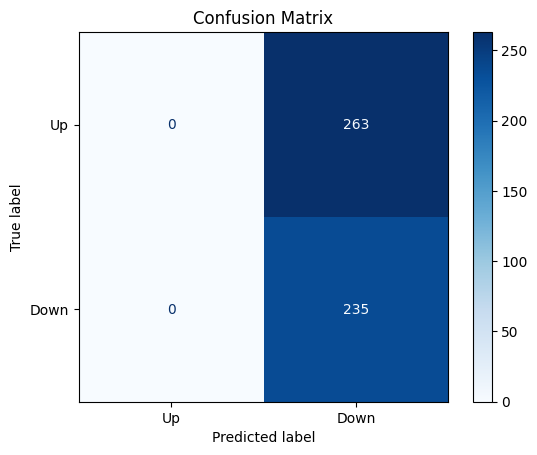

In [ ]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# Validation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for prices, labels in val_loader:
        outputs = model(prices).squeeze()
        predicted = (outputs >= 0.5).float()
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())

# Calculate precision and recall
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
print(f'Validation Precision: {precision:.4f}')
print(f'Validation Recall: {recall:.4f}')

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Up', 'Down'])
cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
torch.save(model, "LSTM_seq_30.pt")

In [ ]:
model.eval()
index = 25500
with torch.no_grad():
    array_seq = df_all.iloc[index-sequence_length:index].values
    print("time: ", array_seq[-1, 0], )
    display(df_all.iloc[index])
    tens_seq = torch.tensor(array_seq[:,1:].astype(np.float32), dtype=torch.float32).unsqueeze(0)
    next_movement = model(tens_seq)
    prediction = "Down" if next_movement.item() >= 0.5 else "Up"
    print(f'Predicted next movement: {prediction}')

time:  2024-07-30 09:45:00


timestamp    2024-07-30 10:00:00
open                       37.38
high                       37.54
low                        37.32
close                      37.51
volumn                   4735.03
Name: 25500, dtype: object

Predicted next movement: Up


In [ ]:
array_seq[:,1:]

array([[   37.16,    37.43,    37.12,    37.37,  6142.39],
       [   37.38,    37.5 ,    37.22,    37.5 ,  7726.35],
       [   37.51,    37.75,    37.44,    37.73,  7304.18],
       [   37.72,    37.8 ,    37.57,    37.64,  6155.4 ],
       [   37.65,    37.77,    37.23,    37.3 , 10241.47],
       [   37.3 ,    37.31,    37.04,    37.17, 12321.35],
       [   37.16,    37.44,    37.13,    37.37,  5225.59],
       [   37.39,    37.41,    36.94,    37.01,  9231.01],
       [   36.99,    37.17,    36.96,    37.16,  9114.22],
       [   37.16,    37.41,    37.15,    37.38,  1893.64]], dtype=float32)

In [ ]:
import time
from datetime import datetime
from binance.spot import Spot
from binance_ft.um_futures import UMFutures
from helper import get_commision, get_precision, get_status_pos, key, secret, xlsx_to_nested_dict
from datetime import datetime, timedelta

# Initialize the Binance client
api_key="7NvUEUX4tnzOja5KQ99gmUG37DQOV9oelvz1akWAr2Zts9X57djRMwbvfgjQoykp"
api_secret="X9CWCXNsdypjEU8Q0AQaoaqPrcnaX4wpDe5KVxsAfThkVJJAvufiGJ3tb95QqnQC"
# client = UMFutures(key="c21f1bb909318f36de0f915077deadac8322ad7df00c93606970441674c1b39b", secret="be2d7e74239b2e959b3446b880451cbb4dee2e6be9d391c4c55ae7ca0976f403", base_url="https://testnet.binancefuture.com")
client = UMFutures(key=api_key, secret=api_secret)
def get_latest_kline_start_time(symbol, interval):
    klines = client.klines(symbol=symbol, interval=interval, limit=3)
    kline_start_time = int(klines[-1][0])
    return datetime.fromtimestamp(kline_start_time / 1000), klines

    

# Example usage
symbol = 'ORDIUSDT'
interval = '15m'
usdt = 1000
precision_ft = get_precision(symbol, client)
while True:
    kline_start_time, klines = get_latest_kline_start_time(symbol, interval)
    print(kline_start_time)
    next_kline_start_time = kline_start_time + timedelta(minutes=15)
    
    now = datetime.now()
    sleep_duration = (next_kline_start_time - now).total_seconds()    
    if sleep_duration > 0:
        print(f"Sleeping for {sleep_duration} seconds until the next kline starts...")
        time.sleep(sleep_duration)
        current_kline_time, klines = get_latest_kline_start_time(symbol, interval)
        ohlc = []
        for item in klines:
            ohlc.append({
                'timestamp': datetime.fromtimestamp(item[0] / 1000),
                'open': float(item[1]),
                'high': float(item[2]),
                'low': float(item[3]),
                'close': float(item[4])
            })
        df = pd.DataFrame(ohlc)
        df['fluct'] = (df['close'] - df['open']) / df['open'] * 100
        if current_kline_time>kline_start_time:
            print("A new kline has started!")
        else:
            print("In current kline")
            if df['fluct'].iloc[-1] < -0.8 and df['fluct'].iloc[-2] >0:
                order_price = df.iloc[-1]['close']
                high = order_price * 1.05
                low = order_price * 0.99
                print(current_kline_time, order_price, high, low)
                quantity_ft = round((usdt)/order_price, precision_ft)
                print("open")
                # close_future = client.new_order(symbol=symbol, side="SELL", type="MARKET", quantity=quantity_ft)
                while True:
                    askPrice = float(client.book_ticker(symbol)['askPrice'])
                    print("waiting_close...")
                    if askPrice > high or askPrice < low:

                        print(time.strftime("%Y-%m-%d %H:%M:%S"),"close", askPrice, high, low)
                        # close_future = client.new_order(symbol=symbol, side="BUY", type="MARKET", quantity=quantity_ft)
                        break
                    time.sleep(1)
            else:
                display(df)
    else:
        time.sleep(2)


2024-07-31 23:15:00
Sleeping for 431.366068 seconds until the next kline starts...


KeyboardInterrupt: 